In [1]:
import torch
from msdm.domains import GridWorld
from msdm.core.problemclasses.mdp import TabularPolicy
from msdm.algorithms import PolicyIteration
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration

In [2]:
gw_params = dict(
    tile_array=[
        "..b.g",
        "..b..",
        "aa.aa",
        "..b..",
        "s.b..",
    ],
    feature_rewards={
        "a": -100,
        "b": 0,
    },
    discount_rate=1-1e-5,
    step_cost=-1
    
)
gw = GridWorld(**gw_params)

erpi_params = dict(
    transition_matrix=torch.tensor(gw.transition_matrix),
    reward_matrix=torch.tensor(gw.reward_matrix),
    discount_rate=torch.tensor(gw.discount_rate),
    entropy_weight=torch.tensor([5]), # the lower this is, the more optimal the policy
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

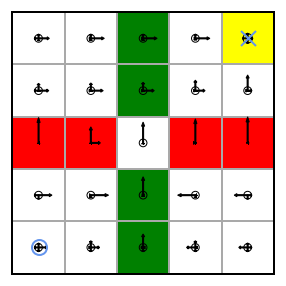

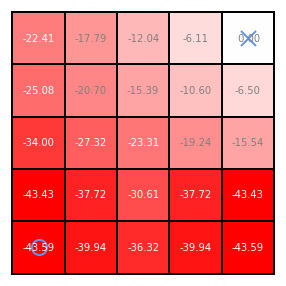

In [3]:
# solve with matrices returned by gridworld object
original_erpi = entropy_regularized_policy_iteration(
    **erpi_params
)
policy = TabularPolicy.from_matrix(
    states=gw.state_list,
    actions=gw.action_list,
    policy_matrix=original_erpi.policy.detach().numpy()
)
state_values = dict(zip(gw.state_list, original_erpi.state_values))
gw.plot(featurecolors={'a': 'r', 'b': 'g', 'g': 'yellow'}).plot_policy(policy)
gw.plot().plot_state_map(state_values)

In [4]:
# construct an equivalent reward function with feature matrices
def create_feature_matrix(gw, features):
    state_feature_matrix = torch.zeros(len(gw.state_list), len(features))
    for si, s in enumerate(gw.state_list):
        f = gw.location_features.get(s, '.')
        if f in features:
            fi = features.index(f)
        else:
            continue
        state_feature_matrix[si, fi] = 1
    state_action_nextstate_feature_matrix = state_feature_matrix[None, None, :]
    return state_action_nextstate_feature_matrix

def create_step_cost_matrix(gw):
    # action at every state has a step cost, except the terminal state
    state_step_cost_matrix = torch.tensor(gw.step_cost)*gw.nonterminal_state_vec
    step_cost_matrix = state_step_cost_matrix[:, None, None]
    return step_cost_matrix

# get features and feature reward_weights
features = sorted(gw_params['feature_rewards'].keys())
features = [f for f in features if f not in 'gs']
feature_reward_weights = torch.tensor([float(gw_params['feature_rewards'][f]) for f in features])

# create reward_matrix from features
feature_matrix = create_feature_matrix(gw, features)
feature_reward_matrix = torch.einsum(
    "sanf,f->san", 
    feature_matrix,
    feature_reward_weights
).double()
step_cost_matrix = create_step_cost_matrix(gw)
reward_matrix = feature_reward_matrix + step_cost_matrix

# this should be |S| x 1 x |S| since its the same for all actions
assert tuple(reward_matrix.shape) == (len(gw.state_list), 1, len(gw.state_list))
reward_matrix[:,:,0] = 0 #anything leading to the terminal state ({-1, -1}) has zero reward

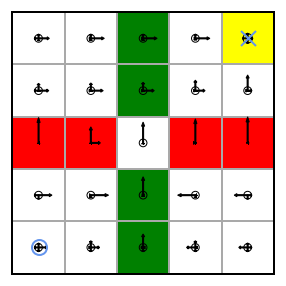

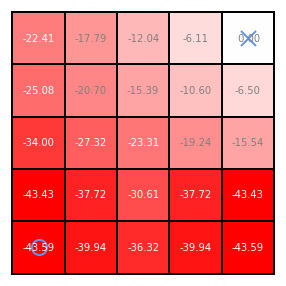

In [5]:
new_erpi = entropy_regularized_policy_iteration(**{
    **erpi_params,
    "reward_matrix": reward_matrix # this overrides the entry in erpi_params
})
policy = TabularPolicy.from_matrix(
    states=gw.state_list,
    actions=gw.action_list,
    policy_matrix=new_erpi.policy.detach().numpy()
)
state_values = dict(zip(gw.state_list, new_erpi.state_values))
gw.plot(featurecolors={'a': 'r', 'b': 'g', 'g': 'yellow'}).plot_policy(policy)
gw.plot().plot_state_map(state_values)

In [6]:
# the reward function is exactly the same, so the resulting state values
# should be exactly the same
assert (original_erpi.state_values - new_erpi.state_values).sum() == 0